# AON & ACTION DATA - PREPROCESSING

Author: Olaf Borghi

This script was run in a dockerized environment, to make sure that it is replicable.
To see all installed libraries, see https://github.com/olafborghi/AON_ACTION/blob/main/Docker/Dockerfile

FSL was used for preprocessing (but SPM12 and ANTS are available as well within the environment if needed).
Some inspiration was taken from: https://peerherholz.github.io/workshop_weizmann/nipype/notebooks/handson_preprocessing.html

### Setting up the environment

In [22]:
import os

fslpath="/usr/share/fsl/5.0" 
os.environ["FSLDIR"] = fslpath
os.environ["PATH"] += os.pathsep + os.path.join(fslpath, "bin")
!. ${FSLDIR}/etc/fslconf/fsl.sh
!export FSLDIR PATH

os.environ["LD_LIBRARY_PATH"] = os.environ["LD_LIBRARY_PATH"] + os.pathsep + "/usr/lib/fsl/5.0"

# add mni template to fsl dir
!mkdir /usr/share/fsl/5.0/data/standard
!wget 'https://ucloud.univie.ac.at/index.php/s/bnj6HPWqImlpFjD/download' -O /tmp/mniatlas.zip
!unzip /tmp/mniatlas.zip -d /usr/share/fsl/5.0/data/standard

mkdir: cannot create directory ‘/usr/share/fsl/5.0/data/standard’: File exists
--2022-12-19 14:36:46--  https://ucloud.univie.ac.at/index.php/s/bnj6HPWqImlpFjD/download
Resolving ucloud.univie.ac.at (ucloud.univie.ac.at)... 131.130.68.37, ::ffff:131.130.68.37, 2001:62a:4:7:131:130:68:37
Connecting to ucloud.univie.ac.at (ucloud.univie.ac.at)|131.130.68.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55031889 (52M) [application/zip]
Saving to: ‘/tmp/mniatlas.zip’

/tmp/mniatlas.zip   100%[===================>]  52.48M  11.8MB/s    in 4.7s    

2022-12-19 14:36:51 (11.2 MB/s) - ‘/tmp/mniatlas.zip’ saved [55031889/55031889]

Archive:  /tmp/mniatlas.zip
replace /usr/share/fsl/5.0/data/standard/avg152T1_brain.nii.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### Importing libraries/modules

In [26]:
# Import necessary packages and modules
%matplotlib inline
import numpy as np
import nibabel as nib
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import Image
import json

from nipype import Node, Workflow
from nipype.interfaces import fsl
from nipype.interfaces.fsl.utils import RobustFOV
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12-r7219/spm12_mcr/spm12')
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.utility import IdentityInterface
from nipype.algorithms.rapidart import ArtifactDetect

from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting, datasets, image

Let's look at the folder structure and set the paths necessery for our analysis steps.

In [27]:
# Quick look at our data folder structure
!tree /data/ -I '*js|*json|*pklz|_report|*dot|*html|*txt|*.m'

/data/
├── output
│   └── working_dir
│       ├── coreg_wf
│       │   └── graph.png
│       ├── fieldmap_wf
│       │   └── graph.png
│       ├── norm_wf
│       │   └── graph.png
│       └── test_workflow
│           ├── coreg_wf
│           │   └── _subject_id_01
│           │       └── _task_run_id_AON_run-01
│           │           ├── applywarp
│           │           │   ├── sub-01_task-AON_run-01_bold_roi_st_mcf_flirt.mat
│           │           │   └── sub-01_task-AON_run-01_bold_roi_st_mcf_flirt.nii
│           │           ├── bet_anat
│           │           │   └── sub-01_T1w_ROI_brain.nii.gz
│           │           ├── coreg_bbr
│           │           │   └── sub-01_task-AON_run-01_bold_roi_st_mcf.nii.gz_mean_reg_flirt.mat
│           │           ├── coreg_pre
│           │           │   └── sub-01_task-AON_run-01_bold_roi_st_mcf.nii.gz_mean_reg_flirt.mat
│           │           ├── segmentation
│           │           │   ├── sub-01_T1w_ROI_brain_pve_0.nii.gz
│          

├── sub-14
│   ├── anat
│   │   └── sub-14_T1w.nii.gz
│   ├── fmap
│   │   ├── sub-14_magnitude1.nii.gz
│   │   ├── sub-14_magnitude2.nii.gz
│   │   └── sub-14_phasediff.nii.gz
│   └── func
│       ├── sub-14_task-action_bold.nii.gz
│       ├── sub-14_task-action_events.tsv
│       ├── sub-14_task-AON_run-01_bold.nii.gz
│       ├── sub-14_task-AON_run-01_events.tsv
│       ├── sub-14_task-AON_run-02_bold.nii.gz
│       └── sub-14_task-AON_run-02_events.tsv
├── sub-15
│   ├── anat
│   │   └── sub-15_T1w.nii.gz
│   ├── fmap
│   │   ├── sub-15_magnitude1.nii.gz
│   │   ├── sub-15_magnitude2.nii.gz
│   │   └── sub-15_phasediff.nii.gz
│   └── func
│       ├── sub-15_task-action_bold.nii.gz
│       ├── sub-15_task-action_events.tsv
│       ├── sub-15_task-AON_run-01_bold.nii.gz
│       ├── sub-15_task-AON_run-01_events.tsv
│       ├── sub-15_task-AON_run-02_bold.nii.gz
│       └── sub-15_task-AON_run-02_events.tsv
├── sub-16
│   ├── anat
│   │   └── sub-16_T1w.nii.gz
│   ├── fmap
│   │   ├──

├── sub-34
│   ├── anat
│   │   └── sub-34_T1w.nii.gz
│   ├── fmap
│   │   ├── sub-34_magnitude1.nii.gz
│   │   ├── sub-34_magnitude2.nii.gz
│   │   └── sub-34_phasediff.nii.gz
│   └── func
│       ├── sub-34_task-action_bold.nii.gz
│       ├── sub-34_task-action_events.tsv
│       ├── sub-34_task-AON_run-01_bold.nii.gz
│       ├── sub-34_task-AON_run-01_events.tsv
│       ├── sub-34_task-AON_run-02_bold.nii.gz
│       └── sub-34_task-AON_run-02_events.tsv
├── sub-35
│   ├── anat
│   │   └── sub-35_T1w.nii.gz
│   ├── fmap
│   │   ├── sub-35_magnitude1.nii.gz
│   │   ├── sub-35_magnitude2.nii.gz
│   │   └── sub-35_phasediff.nii.gz
│   └── func
│       ├── sub-35_task-action_bold.nii.gz
│       ├── sub-35_task-action_events.tsv
│       ├── sub-35_task-AON_run-01_bold.nii.gz
│       ├── sub-35_task-AON_run-01_events.tsv
│       ├── sub-35_task-AON_run-02_bold.nii.gz
│       └── sub-35_task-AON_run-02_events.tsv
├── sub-36
│   ├── anat
│   │   └── sub-36_T1w.nii.gz
│   ├── fmap
│   │   ├──

In [28]:
# create directories
!mkdir -p /data/output/working_dir

# set paths for experiment dir, working dir and output dir
working_dir = "/data/output/working_dir"
data_dir = "/data"
output_dir = "/data/output"

# specify subjects and tasks/runs to be preprocessed

# define the ID of your subject (to test it, I will only preprocess two subjects for now)
subject_list = ["01"] # add more sbj-IDs to the list if you want to preprocess them as well 

# define the tasks & runs that I want to preprocess
# add "AON_run-2", "action"
task_run_list = ["AON_run-01"]

-------
### First look at the data

Plot the anatomical image:

Subject: sub-01
Shape of anatomical data: (176, 256, 256)


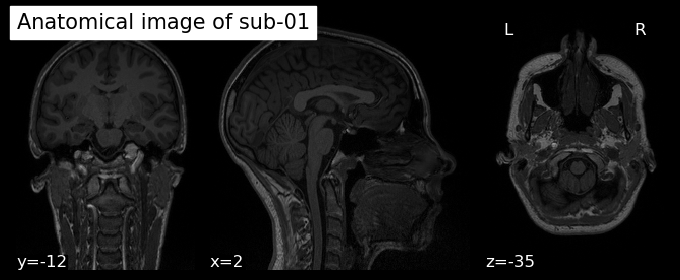

In [8]:
for sbj in subject_list:
 
    anat_dir = f"{data_dir}/sub-{sbj}/anat/sub-{sbj}_T1w.nii.gz"

    # load anatomical img 
    anat_img = nib.load(anat_dir)
    anat_data = anat_img.get_fdata()
    anat_header = anat_img.header 
  
    print("Subject:", f"sub-{sbj}")
    print("Shape of anatomical data:", anat_data.shape)
  
    # anatomical plot
    plotting.plot_anat(anat_img, title = f"Anatomical image of sub-{sbj}", draw_cross = False)

Subject: sub-01
AON Run 1 Slices: 52 AON Run 1 Voxel size: 2.0 AON Run 1 TR: 1.2 AON Run 1 TA: 1.1769231236897981
Shape of AON Run 1 functional data: (96, 96, 52, 273)
AON Run 2 Slices: 52 AON Run 2 Voxel size: 2.0 AON Run 2 TR: 1.2 AON Run 2 TA: 1.1769231236897981
Shape of AON Run 2 functional data: (96, 96, 52, 271)
ACTION Slices: 52 ACTION Voxel size: 2.0 ACTION TR: 1.2 ACTION TA: 1.1769231236897981
Shape of ACTION Run functional data: (96, 96, 52, 218)


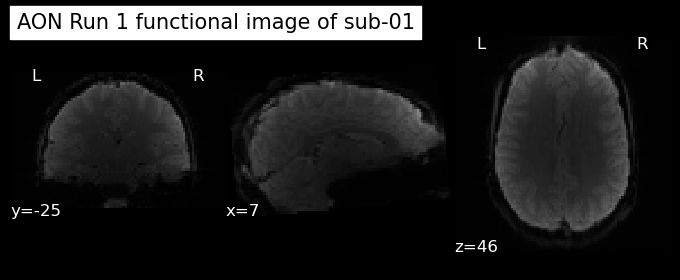

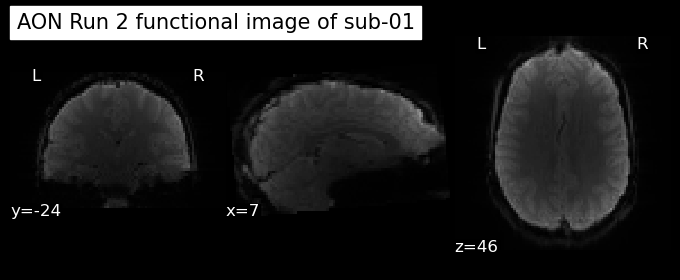

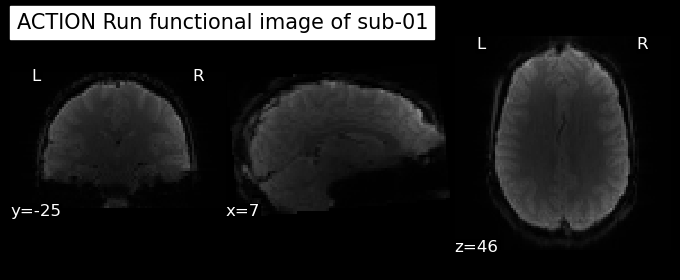

In [10]:
 for sbj in subject_list:   
    
    print("Subject:", f"sub-{sbj}")
    
    # load functional img 
    
    # AON Run 1
    aon_run1_dir = f"{data_dir}/sub-{sbj}/func/sub-{sbj}_task-AON_run-01_bold.nii.gz"
    aon_run1_func_img = nib.load(aon_run1_dir)
    aon_run1_func_data = aon_run1_func_img.get_fdata()
    aon_run1_func_header = aon_run1_func_img.header 
    # AON Run 2
    aon_run2_dir = f"{data_dir}/sub-{sbj}/func/sub-{sbj}_task-AON_run-02_bold.nii.gz"
    aon_run2_func_img = nib.load(aon_run2_dir)
    aon_run2_func_data = aon_run2_func_img.get_fdata()
    aon_run2_func_header = aon_run2_func_img.header 
    # ACTION Run
    action_dir = f"{data_dir}/sub-{sbj}/func/sub-{sbj}_task-action_bold.nii.gz"
    action_func_img = nib.load(action_dir)
    action_func_data = action_func_img.get_fdata()
    action_func_header = action_func_img.header
  
    # define variables for the number of slices, the voxel size, tr and ta
    
    # AON Run 1
    aon_run1_slices = aon_run1_func_data.shape[2]
    aon_run1_voxel_size = aon_run1_func_header.get_zooms()[0]
    aon_run1_TR = aon_run1_func_header.get_zooms()[3]
    aon_run1_TA = aon_run1_TR - (aon_run1_TR/aon_run1_slices)
    print("AON Run 1 Slices:", aon_run1_slices, "AON Run 1 Voxel size:", 
          aon_run1_voxel_size, "AON Run 1 TR:", aon_run1_TR, "AON Run 1 TA:", aon_run1_TA)
    print("Shape of AON Run 1 functional data:", aon_run1_func_data.shape)
    
    # AON Run 2
    aon_run2_slices = aon_run2_func_data.shape[2]
    aon_run2_voxel_size = aon_run2_func_header.get_zooms()[0]
    aon_run2_TR = aon_run2_func_header.get_zooms()[3]
    aon_run2_TA = aon_run2_TR - (aon_run2_TR/aon_run2_slices)
    print("AON Run 2 Slices:", aon_run2_slices, "AON Run 2 Voxel size:", 
          aon_run2_voxel_size, "AON Run 2 TR:", aon_run2_TR, "AON Run 2 TA:", aon_run2_TA)
    print("Shape of AON Run 2 functional data:", aon_run2_func_data.shape)
    
    # ACTION Run
    action_slices = action_func_data.shape[2]
    action_voxel_size = action_func_header.get_zooms()[0]
    action_TR = action_func_header.get_zooms()[3]
    action_TA = action_TR - (action_TR/action_slices)
    print("ACTION Slices:", action_slices, "ACTION Voxel size:", 
          action_voxel_size, "ACTION TR:", action_TR, "ACTION TA:", action_TA)
    print("Shape of ACTION Run functional data:", action_func_data.shape)
    
    # plot the functional raw images
    
    # AON Run 1
    aon_run1_func_img_mean = image.mean_img(aon_run1_dir)
    plotting.plot_anat(aon_run1_func_img_mean, title = f"AON Run 1 functional image of sub-{sbj}", 
                       draw_cross = False, black_bg = True)
    
    # AON Run 2
    aon_run2_func_img_mean = image.mean_img(aon_run2_dir)
    plotting.plot_anat(aon_run2_func_img_mean, title = f"AON Run 2 functional image of sub-{sbj}", 
                       draw_cross = False, black_bg = True)
    
    # ACTION Run
    action_func_img_mean = image.mean_img(action_dir)
    plotting.plot_anat(action_func_img_mean, title = f"ACTION Run functional image of sub-{sbj}", 
                       draw_cross = False, black_bg = True)

Subject: sub-01


/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


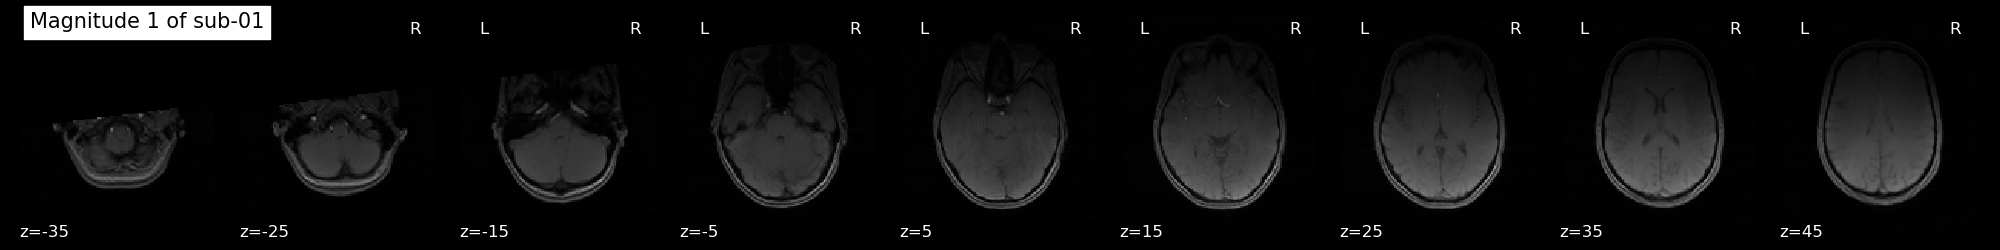

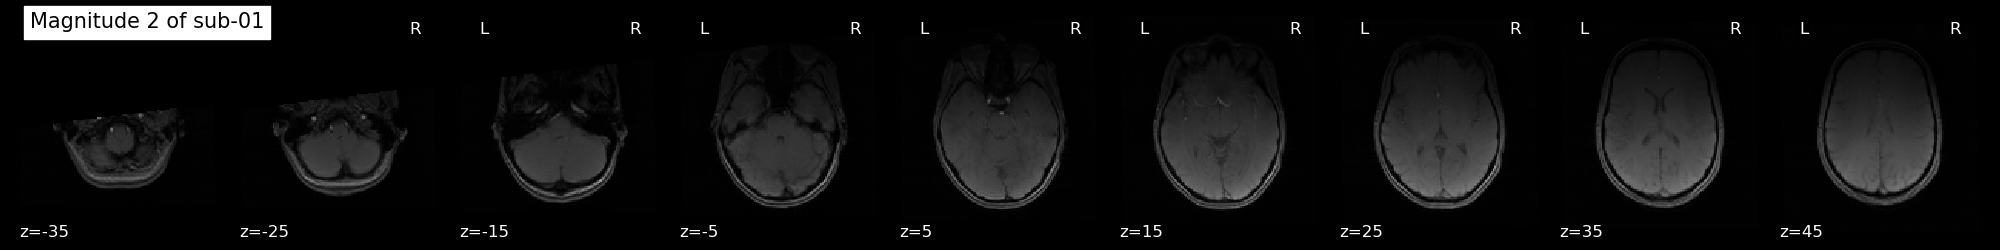

In [15]:
# plot the magnitude fieldmaps

for sbj in subject_list:   
    
    print("Subject:", f"sub-{sbj}")
    
    # load fmap magnitude images
    
    # Magnitude 1
    mag1_dir = f"{data_dir}/sub-{sbj}/fmap/sub-{sbj}_magnitude1.nii.gz"
    mag1_img = nib.load(mag1_dir)
    # Magnitude 2
    mag2_dir = f"{data_dir}/sub-{sbj}/fmap/sub-{sbj}_magnitude2.nii.gz"
    mag2_img = nib.load(mag2_dir)
    
    # plot them
    plotting.plot_anat(mag1_img, title = f"Magnitude 1 of sub-{sbj}", draw_cross = False, 
                       display_mode="z", cut_coords=range(-35,50,10))
    plotting.plot_anat(mag2_img, title = f"Magnitude 2 of sub-{sbj}", draw_cross = False, 
                       display_mode="z", cut_coords=range(-35,50,10))

------
## Preprocessing pipeline



Set up first nodes:

**Infosource** node: To iterate over subjects & tasks (& runs, included in task info)

**Selectfiles** node: Selects the data (func/anat) from the subjects that I would like to preprocess/analyse.

**Datasink**, Storage of the output files from different preprocessing steps. 

In [29]:
## create a main workflow object first

wf = Workflow(name = "test_workflow",
               base_dir = working_dir)

## Setup nodes

# specify iterables
subjects = Node(
    name='subjects',
    interface=IdentityInterface(
        fields=['subject_id']))

subjects.iterables = [('subject_id', subject_list)]

task_run = Node(
    name='task_run',
    interface=IdentityInterface(
        fields=['task_run_id']))

task_run.iterables = [('task_run_id', task_run_list)]

# String template with {}-based strings
templates = {'anat': 'sub-{subject_id}/anat/'
                     'sub-{subject_id}_T1w.nii.gz',
             'func': 'sub-{subject_id}/func/'
                     'sub-{subject_id}_task-{task_run_id}_bold.nii.gz',
             "phasediff": "sub-{subject_id}/fmap/sub-{subject_id}_phasediff.nii.gz",
             "mag1": "sub-{subject_id}/fmap/sub-{subject_id}_magnitude1.nii.gz",
             "mag2": "sub-{subject_id}/fmap/sub-{subject_id}_magnitude2.nii.gz"}

# Create SelectFiles node
selectfiles = Node(SelectFiles(templates,
                               base_directory = data_dir,
                               sort_filelist=True),
                   name='selectfiles')

# Output stream (DataSink)
# I added some substitutions to make the datasink output a tiny bit more clean and ordered, 
# this names the datasink folder of each sbj with its id, making it easy to access the file path
substitutions = [('.nii.gz.par', '.par')]
substitutions += [(f"_subject_id_sub-{s}/", f"sub-{s}/") for s in subject_list]

datasink = Node(DataSink(base_directory=output_dir, substitutions = substitutions),
                name="datasink")

### Temporal preprocessing

Set up the nodes for the temporal preprocessing. 

**Extract** node: Remove the first four volumes of the functional scan (i.e., dummyscans from the scanner).

**Slicetimer** node: Slices from one volume are acquired at different times in the TR. In the slice time correction, this is corrected for. TR and whether or not slices were acquired interleaved has to be corrected for here.

**Realigner** node: Correct for motion of the subject during scanning. Realignment parameters (x,y,z,pitch,roll,yaw deviation from each image relative to the mean volume) are stored, to later inspect this visually.

**Unwarper** node: Measure and correct magnetic field distortions with the fieldmaps

**Smoother** node: Spatial low-pass filter. Each voxel is replaced by the weighted average of itself and neigbouring voxel. This "weighted avarage* is calculated by the full-width-at-halfmaximum (FWHM). Often, the FWHM is set to 2*voxelsize. In this workflow, the FWHM ist set to 4mm (even though the voxel size is 3mm).

**Artifact detector** node: Detects motion and intensity outliers in the functional images.

In [30]:
# remove first four volumes (fsl.ExtractROI)
extract = Node(fsl.ExtractROI(t_min=4, t_size=-1),
               name="extract")

# slicetime correction (fsl.SliceTimer), change "interleaved"
slicetimer = Node(fsl.SliceTimer(time_repetition = 1.2,
                                 interleaved = True),
                  name="slicetimer")

# realignment/motion correction (fsl.MCFLIRT), register to mean volume, save motion parameter
realigner = Node(fsl.MCFLIRT(mean_vol=True,
                             save_plots=True),
                 name="realigner")
  
# smooting (fsl.IsotropicSmooth), fwhm = 4
smoother = Node(fsl.IsotropicSmooth(fwhm = 4),
                 name = "smoother")
  
# artefact detection (algorithms.rapidart.ArtifactDetect)
artifact_detector = Node(ArtifactDetect(norm_threshold=2,
                                        zintensity_threshold=3,
                                        mask_type='spm_global',
                                        parameter_source='FSL',
                                        use_differences=[True, False],
                                        plot_type='svg'),
                         name = "artifact_detector")

## Spatial preprocessing

221219-14:40:19,281 nipype.workflow INFO:
	 Generated workflow graph: /data/output/working_dir/coreg_wf/graph.png (graph2use=colored, simple_form=True).

Coregistration Workflow:


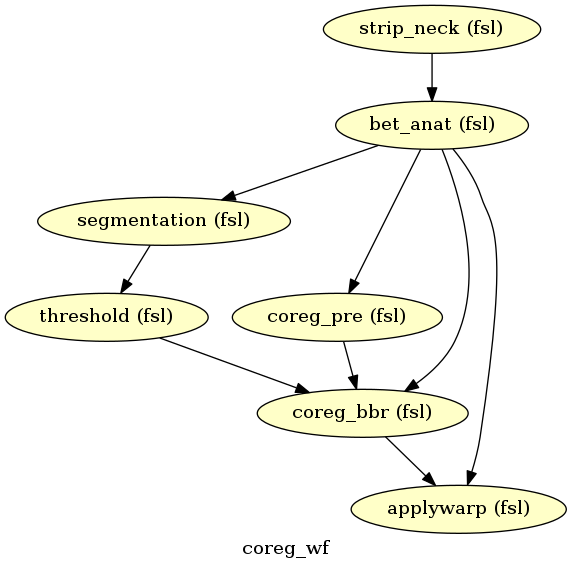

In [35]:
## Create coregistration sub-workflow
## adapted from https://github.com/lrsktr/tewa-neuroimaging/blob/main/Individual-project/scripts/fsl-spatial-preproc.py

coreg_wf = Workflow(name='coreg_wf', base_dir=working_dir)

# Helper function to select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]

# Remove neck from anatomical image to improve skullstripping
strip_neck = Node(RobustFOV(),
                  name="strip_neck")

# Skullstrip anatomical image
bet_anat = Node(fsl.BET(frac=0.2,
                    #reduce_bias=True,
                    output_type='NIFTI_GZ'),
                name="bet_anat")

# T1 segmentation & bias field correction
segmentation = Node(fsl.FAST(output_type='NIFTI_GZ', output_biascorrected=True),
                    name="segmentation", mem_gb=4)

# Threshold WM probability image
threshold = Node(fsl.Threshold(thresh=0.15,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                 name="threshold")

# Pre-alignment of functional images to anatomical images
coreg_pre = Node(fsl.FLIRT(dof=6, output_type='NIFTI_GZ'),
                name="coreg_pre")

# Use BBR cost function to improve the coregistration
coreg_bbr = Node(fsl.FLIRT(dof=6,
                       cost='bbr',
                       schedule=os.path.join(os.getenv('FSLDIR'),"etc/flirtsch/bbr.sch"),      
                       output_type='NIFTI_GZ'),
                 name="coreg_bbr")

# Apply coregistration warp to functional images
applywarp = Node(fsl.FLIRT(interp='spline',
                       apply_isoxfm=4,
                       output_type='NIFTI'),
                 name="applywarp")


# connect nodes of coreg workflow
coreg_wf.connect([  (strip_neck, bet_anat,      [("out_roi", "in_file")]),
                    (bet_anat, segmentation,    [('out_file', 'in_files')]),
                    (segmentation, threshold,   [(('partial_volume_files', get_wm),
                                                  'in_file')]),
                    (bet_anat, coreg_pre,       [('out_file', 'reference')]),
                    (threshold, coreg_bbr,      [('out_file', 'wm_seg')]),
                    (coreg_pre, coreg_bbr,      [('out_matrix_file', 'in_matrix_file')]),
                    (bet_anat, coreg_bbr,       [('out_file', 'reference')]),
                    (coreg_bbr, applywarp,      [('out_matrix_file', 'in_matrix_file')]),
                    (bet_anat, applywarp,       [('out_file', 'reference')])
                ])

# visualizing the coreg-workflow
coreg_wf.write_graph(graph2use="colored", format="png", simple_form=True)
print("\nCoregistration Workflow:")
Image(filename=f"{working_dir}/{coreg_wf}/graph.png")

221219-14:40:19,880 nipype.workflow INFO:
	 Generated workflow graph: /data/output/working_dir/norm_wf/graph.png (graph2use=colored, simple_form=True).
Normalization Workflow:


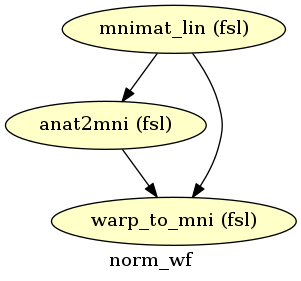

In [36]:
## Create normalization sub-workflow
## adapted from https://github.com/lrsktr/tewa-neuroimaging/blob/main/Individual-project/scripts/fsl-spatial-preproc.py

norm_wf = Workflow(name='norm_wf', base_dir=working_dir)

# set reference space (MNI template)
reference = os.path.join(os.getenv('FSLDIR'), 'data/standard/MNI152_T1_2mm_brain.nii.gz')

# linear transformation of t1 to mni template
mnimat_lin = Node(fsl.FLIRT(cost_func="normcorr", dof=12, reference=reference),
                  name="mnimat_lin")   

# non-linear transformation of t1 to mni (using params from linear transf.)                                                                                
anat2mni = Node(fsl.FNIRT(ref_file=reference, warped_file="warped.nii"),
                name="anat2mni") 

# warp epi data to mni template
warp_to_mni = Node(fsl.ApplyWarp(ref_file=reference),
                   name="warp_to_mni") 

# connect the norm wf
norm_wf.connect([(mnimat_lin, anat2mni,    [("out_matrix_file", "affine_file")]),
                 (anat2mni, warp_to_mni,   [("field_file", "field_file")]),
                 (mnimat_lin, warp_to_mni, [("out_matrix_file", "postmat")]),
                ])    

# visualize the norm wf
norm_wf.write_graph(graph2use="colored", format="png", simple_form=True)
print("Normalization Workflow:")
Image(filename=f"{working_dir}/{norm_wf}/graph.png")

221219-14:40:21,816 nipype.workflow INFO:
	 Generated workflow graph: /data/output/working_dir/fieldmap_wf/graph.png (graph2use=colored, simple_form=True).

Fieldmap Workflow:


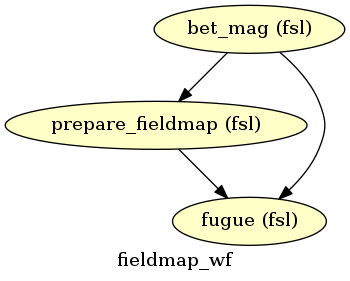

In [37]:
## Create fieldmap workflow, adapted from https://notebook.community/chrisfilo/fmri-analysis-vm/analysis/preprocessing/Preprocessing

fieldmap_wf = Workflow(name='fieldmap_wf', base_dir=working_dir)

# extract brain from magnitude; Siemens scanners usally provide 2 magnitude and one phasediff
# it does not matter if its magnitude 1 or magnitude 2, pick the better looking one, but both are fine
# brain extraction should be tight and exclude all non-brain voxels 
bet_mag = Node(fsl.BET(functional=True,
                       mask=True,
                       frac=0.65),
              name='bet_mag')

# prepare the fieldmap from Siemens data; in_phase from selectfiles; in_magnitude from bet_mag
prepare_fieldmap = Node(fsl.PrepareFieldmap(),
                       name='prepare_fieldmap')

# unwarping, provide in_file = mean_img from MCFlirt, fmap_in_file = prepeare_fieldmap.out_fieldmap, mask_file = bet_mag.outputs.mask_file
fugue = Node(fsl.FUGUE(unwarp_direction = "y",
                       dwell_time = 2.6/10000.0),
            name="fugue")

# connect fieldmap workflow
fieldmap_wf.connect([ (bet_mag, prepare_fieldmap, [("out_file", "in_magnitude")]),
                      (prepare_fieldmap, fugue,    [("out_fieldmap", "fmap_in_file")]),
                      (bet_mag, fugue,            [("mask_file", "mask_file")])
                    ])

# visualizing the coreg-workflow
fieldmap_wf.write_graph(graph2use="colored", format="png", simple_form=True)
print("\nFieldmap Workflow:")
Image(filename=f"{working_dir}/{fieldmap_wf}/graph.png")

### Connect all the nodes and the sub-workflows

In [38]:
# delete existing workflow and datasink folder if you run the workflow twice in one session (else ignore)
del wf
!rm -rf /output/datasink
# recreate the workflow
wf = Workflow(name = "test_workflow",
               base_dir = working_dir)

221219-14:40:25,249 nipype.workflow INFO:
	 Generated workflow graph: /data/output/working_dir/test_workflow/workflow_graph.png (graph2use=colored, simple_form=True).


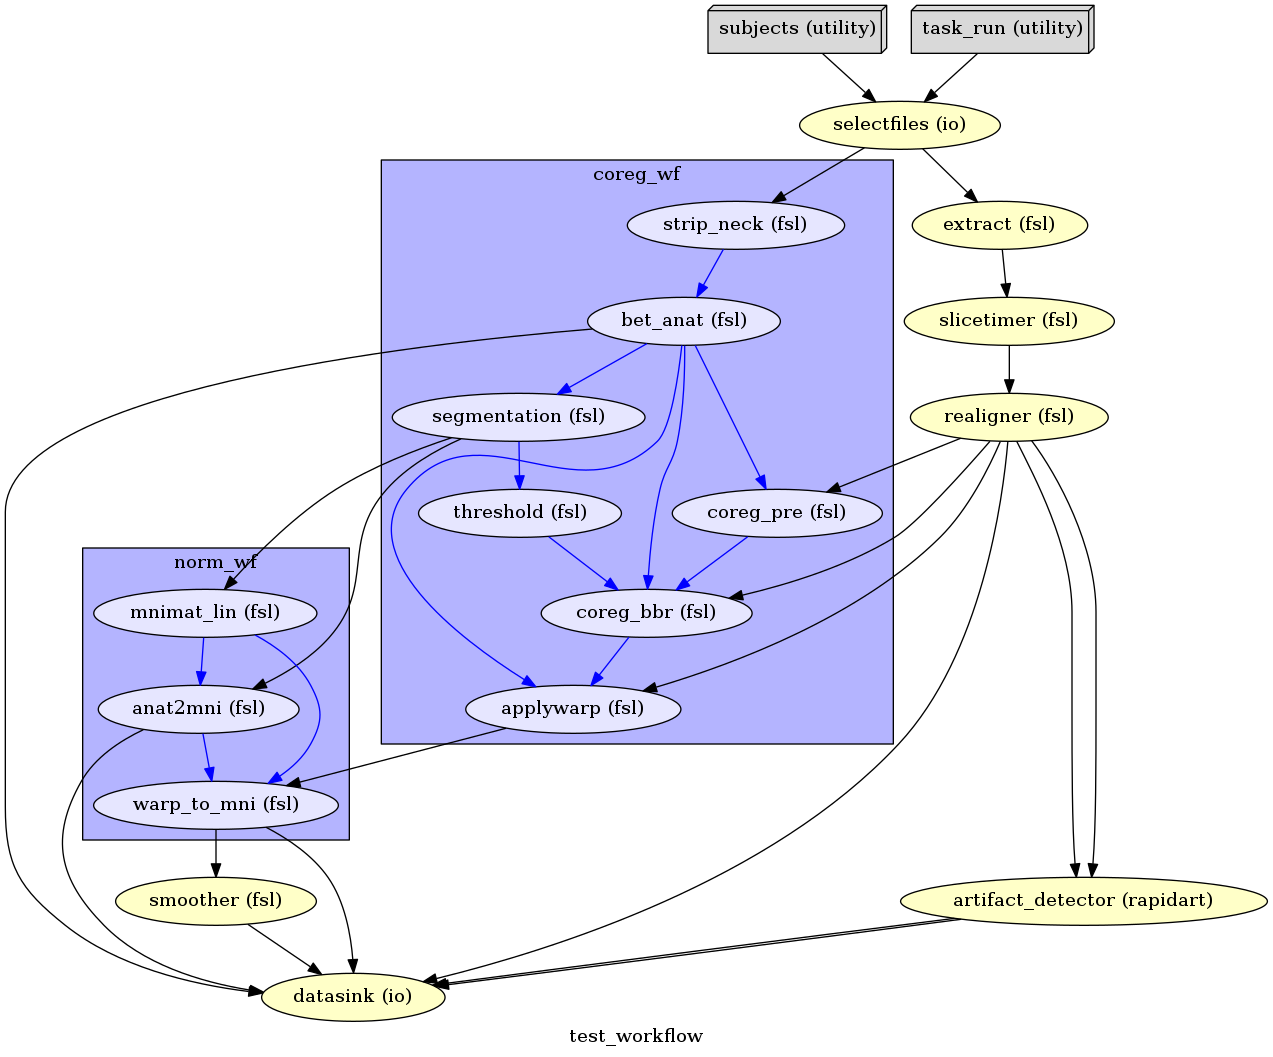

In [39]:
# then connect all nodes
wf.connect([(subjects, selectfiles,  [("subject_id", "subject_id")]), # (subjects -> selectfiles)
            (task_run, selectfiles,  [("task_run_id", "task_run_id")]), # (subjects -> selectfiles)
            (selectfiles, extract,     [("func", "in_file")]), # (selectfiles -> extractROI)
            (extract, slicetimer, [("roi_file", "in_file")]), # (extractROI -> slicetimer)
            (slicetimer, realigner, [("slice_time_corrected_file", "in_file")]), # (slicetimer -> realigner) 
            (realigner, artifact_detector, [("out_file", "realigned_files"), # (realigned func images as input for artifact detection)
                                            ("par_file", "realignment_parameters")]), # (realignmemt pars as input for artifact detection)

            (selectfiles, coreg_wf,  [("anat", "strip_neck.in_file")]), 
            (realigner, coreg_wf, [("mean_img", "coreg_pre.in_file"), # (mean realigned func image as input for Pre-alignment)
                                   ("mean_img", "coreg_bbr.in_file"), # (mean realigned func image as input for bbr coreg)
                                   ("out_file", "applywarp.in_file")]), # (realigned func images as input for applying coreg warp)
                                   
            (coreg_wf, norm_wf, [("segmentation.restored_image", "mnimat_lin.in_file"), # (restored image from segmentation as input for lin. transformation of t1 to mni)
                                 ("segmentation.restored_image", "anat2mni.in_file"), # (restored image from segmentation as input for non-lin. transformation of t1 to mni)
                                 ("applywarp.out_file", "warp_to_mni.in_file")]), # (output of applied coreg warp as input file for warp of func data to mni template)

            (norm_wf, smoother, [("warp_to_mni.out_file", "in_file")]), # (output of warp of func data to mni template as input for smoother)

            (realigner, datasink, [("par_file", "datasink.@realigner")]), # transformation parameters obtained by realignment
            (norm_wf, datasink, [("warp_to_mni.out_file", "datasink.@unsmoothed")]), # unsmoothed functional file warped to mni
            (smoother, datasink, [("out_file", "datasink.@smoothed")]), # smoothed functional file warped to mni
            (coreg_wf, datasink, [("bet_anat.out_file", "datasink.@skullstrip")]), # skullstripped anatomical image
            (norm_wf, datasink, [("anat2mni.warped_file", "datasink.@warped")]), # anatomical image in mni space (warped_file)
            (artifact_detector, datasink, [("outlier_files", "datasink.@outlier_articfacts"), # outlier files of artifact detection
                                           ("plot_files", "datasink.@plot_articfacts")]) # plot files of artifact detection

])

# and finally visualize the final workflow
wf.write_graph("workflow_graph.dot", graph2use="colored", format="png", simple_form=True)
from IPython.display import Image
Image(filename="/data/output/working_dir/test_workflow/workflow_graph.png")

In [40]:
wf.run()

221219-14:40:31,430 nipype.workflow INFO:
	 Workflow test_workflow settings: ['check', 'execution', 'logging', 'monitoring']
221219-14:40:31,675 nipype.workflow INFO:
	 Running serially.
221219-14:40:31,676 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.selectfiles" in "/data/output/working_dir/test_workflow/_subject_id_01/_task_run_id_AON_run-01/selectfiles".
221219-14:40:31,797 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
221219-14:40:31,810 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.007566s.
221219-14:40:31,885 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.extract" in "/data/output/working_dir/test_workflow/_subject_id_01/_task_run_id_AON_run-01/extract".
221219-14:40:31,961 nipype.workflow INFO:
	 [Node] Cached "test_workflow.extract" - collecting precomputed outputs
221219-14:40:31,962 nipype.workflow INFO:
	 [Node] "test_workflow.extract" found cached.
221219-14:40:31,963 nipype.workflow 

221219-14:44:45,951 nipype.workflow INFO:
	 [Node] Setting-up "test_workflow.coreg_wf.applywarp" in "/data/output/working_dir/test_workflow/coreg_wf/_subject_id_01/_task_run_id_AON_run-01/applywarp".
221219-14:44:46,130 nipype.workflow INFO:
	 [Node] Cached "test_workflow.coreg_wf.applywarp" - collecting precomputed outputs
221219-14:44:46,131 nipype.workflow INFO:
	 [Node] "test_workflow.coreg_wf.applywarp" found cached.
221219-14:44:46,133 nipype.workflow INFO:
	 ***********************************
221219-14:44:46,134 nipype.workflow ERROR:
	 could not run node: test_workflow.norm_wf.anat2mni.a0.a0
221219-14:44:46,135 nipype.workflow INFO:
	 crashfile: /data/crash-20221219-144445-root-anat2mni.a0.a0-f333a338-49ca-4431-bb49-cfb86de8d334.pklz
221219-14:44:46,136 nipype.workflow INFO:
	 ***********************************


NodeExecutionError: Exception raised while executing Node anat2mni.

Cmdline:
	fnirt --aff=/data/output/working_dir/test_workflow/norm_wf/_subject_id_01/_task_run_id_AON_run-01/mnimat_lin/sub-01_T1w_ROI_brain_restore_flirt.mat --in=/data/output/working_dir/test_workflow/coreg_wf/_subject_id_01/_task_run_id_AON_run-01/segmentation/sub-01_T1w_ROI_brain_restore.nii.gz --logout=/data/output/working_dir/test_workflow/norm_wf/_subject_id_01/_task_run_id_AON_run-01/anat2mni/sub-01_T1w_ROI_brain_restore_log.txt --ref=/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz --iout=/data/output/working_dir/test_workflow/norm_wf/_subject_id_01/_task_run_id_AON_run-01/anat2mni/warped.nii
Stdout:

Stderr:

Traceback:
	Traceback (most recent call last):
	  File "/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 454, in aggregate_outputs
	    setattr(outputs, key, val)
	  File "/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/nipype/interfaces/base/traits_extension.py", line 330, in validate
	    value = super(File, self).validate(objekt, name, value, return_pathlike=True)
	  File "/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/nipype/interfaces/base/traits_extension.py", line 135, in validate
	    self.error(objekt, name, str(value))
	  File "/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/traits/base_trait_handler.py", line 74, in error
	    raise TraitError(
	traits.trait_errors.TraitError: The 'warped_file' trait of a FNIRTOutputSpec instance must be a pathlike object or string representing an existing file, but a value of '/data/output/working_dir/test_workflow/norm_wf/_subject_id_01/_task_run_id_AON_run-01/anat2mni/warped.nii' <class 'str'> was specified.

	During handling of the above exception, another exception occurred:

	Traceback (most recent call last):
	  File "/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 401, in run
	    outputs = self.aggregate_outputs(runtime)
	  File "/opt/miniconda-latest/envs/neuro/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 461, in aggregate_outputs
	    raise FileNotFoundError(msg)
	FileNotFoundError: No such file or directory '/data/output/working_dir/test_workflow/norm_wf/_subject_id_01/_task_run_id_AON_run-01/anat2mni/warped.nii' for output 'warped_file' of a FNIRT interface


bash: line 1: free: command not found


CalledProcessError: Command 'b'free -h --giga\n'' returned non-zero exit status 127.